In [1]:
import os
os.chdir('../../stylegan2-ada-pytorch')

In [2]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import PIL.Image
from tqdm import tqdm
from glob import glob


In [3]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'

print(f"Using {DEVICE} as device")

Using mps as device


### Import Model

In [4]:
# Load model architecture
experiment_path = "../../Data.nosync/Models/Stylegan2_Ada/Finetuned/00002-stylegan2_ada_images-mirror-auto2-kimg1000-resumeffhq512/"
model_name = "network-snapshot-000920.pkl"
model_path = experiment_path + model_name
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    G = architecture['G_ema'].to(DEVICE)  # torch.nn.Module 
    D = architecture['D'].to(DEVICE)

### Test Random Generation

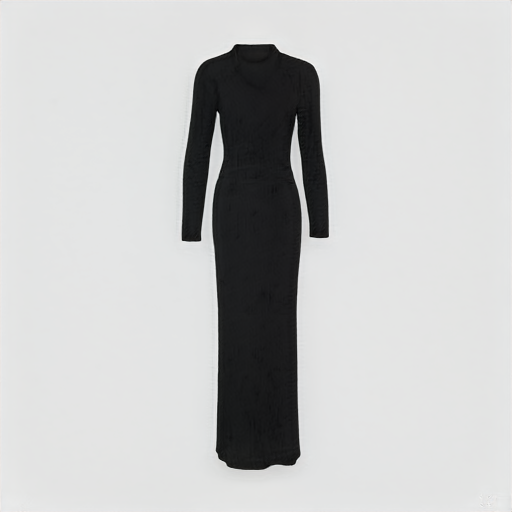

In [5]:
z = torch.randn([1, G.z_dim]).to(DEVICE)    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c,  force_fp32=True) 

img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
PIL.Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

### Test Interpolation

In [6]:
def get_interpolations(seed1, seed2, num_intermediates = 10):
    torch.manual_seed(seed1)
    z1 = torch.randn([1, G.z_dim]).to(DEVICE)
    w1 = G.mapping(z1, c)
    torch.manual_seed(seed2)
    z2 = torch.randn([1, G.z_dim]).to(DEVICE)
    w2 = G.mapping(z2, c)

    # Linearly interpolate between w1 and w2
    interpolated_tensors = []
    for i in range(num_intermediates + 2):  # including w1 and w2
        alpha = i / (num_intermediates + 1)
        interpolated_tensor = torch.lerp(w1, w2, alpha)
        interpolated_tensors.append(interpolated_tensor)

    # Generate images
    imgs = []
    for tensor in tqdm(interpolated_tensors, desc='Generating images'):
        img = G.synthesis(tensor, noise_mode='const')
        img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        imgs.append(PIL.Image.fromarray(img_perm[0].cpu().numpy(), 'RGB'))
    
    return imgs

In [7]:
seed1 = 9082
seed2 = 3454689
num_intermediates = 10

imgs = get_interpolations(seed1, seed2, num_intermediates=num_intermediates)

def show_image(idx):
    plt.figure(figsize=(8, 8))
    plt.imshow(imgs[idx])
    plt.axis('off')
    plt.show()

num_images = len(imgs)
interact(show_image, idx=IntSlider(min=0, max=num_images-1, step=1, value=0))
plt.show()

Generating images: 100%|██████████| 12/12 [00:01<00:00,  6.09it/s]


interactive(children=(IntSlider(value=0, description='idx', max=11), Output()), _dom_classes=('widget-interact…

### Test Reconstruction

1. Choose random original image
2. Project image into w-space
3. Generate new image from w-space
4. Compare original and generated image

In [ ]:
def reconstruct_image(orig_path, num_steps=1000):
    # Load original image
    orig_img = PIL.Image.open(orig_path)

    # Project to latent space
    outdir = orig_path.split('/')[-1].split('.')[0]
    network = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync/Models/Stylegan2_Ada/Finetuned/00002-stylegan2_ada_images-mirror-auto2-kimg1000-resumeffhq512/network-snapshot-000920.pkl"
    CMD = f"python projector.py --outdir={outdir} --target={orig_path} --network={network} --save-video=False --seed=303"
    !{CMD}

    # Load projected latent code
    projected_w = np.load(f"{outdir}/projected_w.npz")['w']

    # Generate image
    projected_w_tensor = torch.tensor(projected_w).to(DEVICE)
    projected_img = G.synthesis(projected_w_tensor, noise_mode='const')
    projected_img_perm = (projected_img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    projected_img_pil = PIL.Image.fromarray(projected_img_perm[0].cpu().numpy(), 'RGB')

    return (orig_img, projected_img_pil)


In [ ]:
orig_images = glob('../../Data.nosync/Zalando_Dataset/dresses/images/stylegan2_ada_images/*/*.png')

NUM_EXAMPLES = 5
reconstuced_imgs = []
for i in range(NUM_EXAMPLES):
    orig_path = np.random.choice(orig_images)
    orig_img, projected_img = reconstruct_image(orig_path, num_steps=1000)
    reconstuced_imgs.append((orig_img, projected_img))

In [ ]:
# Plot the images
fig, axs = plt.subplots(NUM_EXAMPLES, 2, figsize=(8, 8))
for i, (orig_img, projected_img) in enumerate(reconstuced_imgs):
    axs[i, 0].imshow(orig_img)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(projected_img)
    axs[i, 1].axis('off')